# Generative Spaces (ABM)

In this workshop we will learn how to construct a ABM (Agent Based Model) with spatial behaviours, that is capable of configuring the space. This file is a simplified version of Generative Spatial Agent Based Models. For further information, you can find more advanced versions here:

* [Object Oriented version](https://github.com/shervinazadi/spatial_computing_workshops/blob/master/notebooks/w3_generative_spaces.ipynb)
* [Vectorized version](https://topogenesis.readthedocs.io/notebooks/random_walker)

### PesudoCode

```python
# initialization
import pandas, numpy, topogenesis, ...
define stencil & stencil_sq (neighborhood calculation)

# load all results
read lattice, preference, & adjacency matrix
order based on Area
adjust preferences to balance power effect

read dynamical results
fields = {}
for value in dunamical results: 
    fields[name] = value

# initialization agents
for a_id, a_prefs in preferences.iterrows():
    update avail_index
    a_eval = np.ones(len(avail_index))
    # search for the best location inside available lattice
    for f in fields:
        a_eval *= fields[f][avail_index] ** a_prefs[f]
    place agent to maximum point
    update lattices

# calculate distance (estimate)
def distance(a_id,fns):
    dist = []
    for cen in fns_cens:
        dist.append(distance between cen & the central point of a_id)
    return dist

# the agent based model
while t < n_frames:
    for a_id, a_prefs in preferences.iterrows():
        # calculate free neighbors and neighbors for squareness
        fns, fns_sq = [], []
        neighs, neighs_sq = findneigh(stencil,loc[a_id]), findneigh(stencil_sq,loc[a_id])
        for n in neighs:
            if n is avail: fns.append(n)
        for n in neighs_sq:
            if n is avail: fns_sq.append(n)
        
        # the evaluation process
        if len(fns)>0:
            a_eval = np.ones(len(fns))
            # evaluate preference
            for f in fields:
                a_eval *= fields[f][fns] ** a_prefs[f]
            # evaluate closeness to other agents
            for s in agents:
                a_eval *= distance(s,fns) ** weight
            # evaluate squareness
            fns_count = []
            for fn in fns:
                fns_count.append(fns_sq.count(fn))
            a_eval *= fns_count ** square_weight

            # if the agent has reached its desired space
            calculate current_length
            if current_length >= max_space:
                (calculate preference & closeness)
                # evaluate squareness
                i_neighs_count = np.zeros(current_length)
                for id,loc in enumerate(a_locs):
                    neighs = findneigh(stencil_sq,loc)
                    for n in neighs:
                        i_neighs_count[id] += (occ_lattice==a_id)[n]
                i_eval *= i_neighs_count ** square_weight
            
            # find lowest inner value
            selected_int_inner = np.argmin(i_eval)
            # find largerst fns value
            selected_int = np.argmax(a_eval)

            # if the agent has reached its desired space and the fns is better
            if current_length >= max_space and min(a_eval) > max(i_eval):
                remove the inner voxel
            
            # add the new voxel
            if not current_length >= max_space:
                add selected new voxel
    
    construct new_occ_lattice
    frames.append(new_occ_lattice)
    t += 1

# visualization and saving
visualize
save the frames to csv
```

## 0. Initialization

### 0.1. Load required libraries

In [1]:
# !pip install pyvista==0.28.1 ipyvtklink

In [2]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
import scipy as sp
import pickle
import matplotlib.pyplot as plt
np.random.seed(0)

## Parameter settings

In [3]:
# The number of frames of the growth model
n_frames = 200

### 0.2. Define the Neighborhood (Stencil)

In [4]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)

In [5]:
# creating neighborhood definition
stencil_sq = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
# stencil_sq.set_index([0,0,0], 0)
stencil_sq.set_index([0,0,1], 0)
stencil_sq.set_index([0,0,-1], 0)

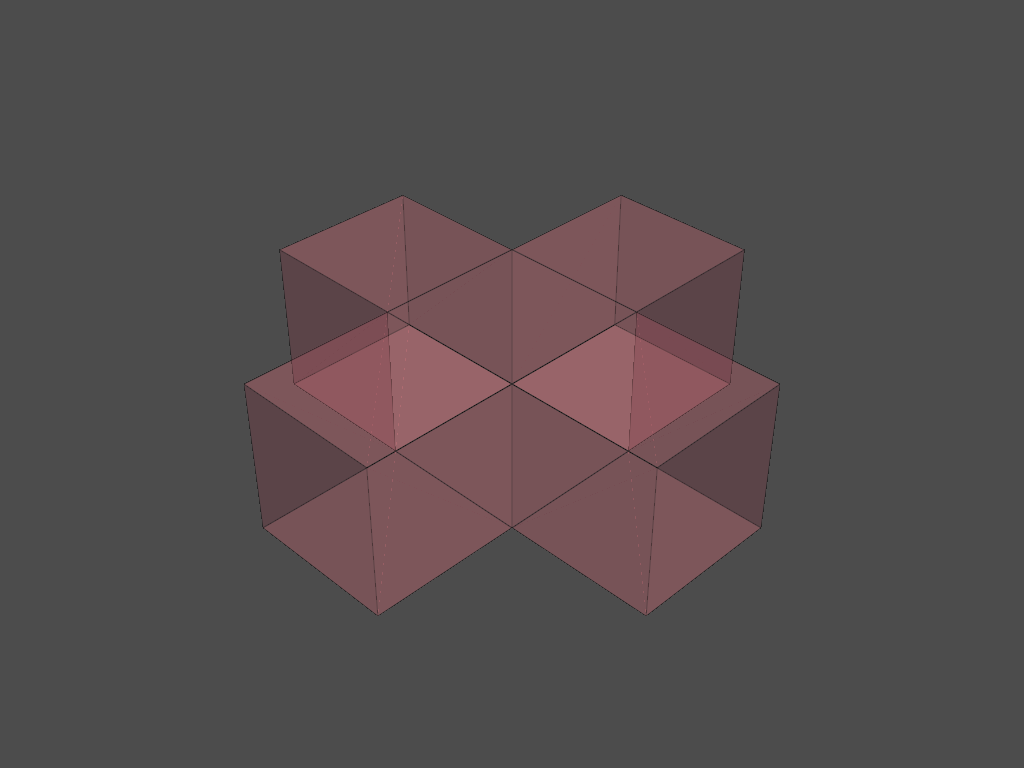

[(6.361720043489708, 6.361720043489708, 6.361720043489708),
 (1.5, 1.5, 1.5),
 (0.0, 0.0, 1.0)]

In [6]:
p = pv.Plotter(notebook=True)
grid = pv.UniformGrid()

grid.dimensions = np.array(stencil_sq.shape) + 1
grid.origin = [0,0,0]
grid.spacing = [1,1,1]

grid.cell_arrays["values"] = stencil_sq.flatten(order="F")
threshed = grid.threshold([0.9, 1.1])

p.add_mesh(threshed, show_edges=True, color="#ff8fa3", opacity=0.3)
p.show()

## 1. Setup the Environment

### 1.1. Load the envelope lattice as the avialbility lattice

In [7]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope_cut.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

### 1.2 Load Program

In [8]:
# Load agent sizes
sizes_complete = pd.read_csv("../Data/raw data/Agent_sizes.csv")
Area = sizes_complete['Area']
sizes_complete = sizes_complete.sort_values(by = 'Area', ascending=0)
display(sizes_complete)

,Agent,Agent_id,Area
6,Vegetation,6,10000
3,Starter housing (100 units),3,9000
1,Student housing (4 persons),1,4800
4,Parking spaces (minimal of 0.5 per apartement),4,4000
9,Co-working space,9,3000
0,Student housing (1 person),0,2400
7,Workshops,7,2000
10,Start-up offices,10,2000
2,Assisted living (30 units),2,1800
17,Restaurant,17,1000


In [9]:
# Calculating agent sizes in voxels
agent_areas = []
for i, row in sizes_complete.iterrows():
    part = row['Area']
    agent_areas.append(part)

In [10]:
# Load preference
square_weight = 0.1

program_complete = pd.read_csv("../Data/raw data/Programme_pref.csv")
program_complete = program_complete.drop(["sunlight"], 1)
program_complete['noise_field'] *= -1
program_complete['dist_entrance'] *= -0.5
program_complete['dist_fac'] *= -0.5

program_complete['Area'] = Area
program_complete = program_complete.sort_values(by='Area',ascending=0)
program_complete = program_complete.drop(['Area'],1)

program_complete

,space_name,space_id,noise_field,dist_entrance,dist_fac,skyview
6,Vegetation/park,6,-0.5,-0.175,-0.265,0.0
3,Starter Housing,3,-0.6,-0.300,-0.465,0.6
1,Student Housing 4 p,1,-0.4,-0.275,-0.435,0.6
4,Underground Parking4,0,-0.8,-0.035,-0.100,0.0
9,Co-working Space,9,-0.5,-0.300,-0.335,0.4
0,Student Housing 1 p,0,-0.4,-0.275,-0.435,0.6
7,Workshops,7,-0.3,-0.325,-0.350,0.4
10,Start-up Offices,10,-0.2,-0.300,-0.300,0.6
2,Assisted Living,2,-0.8,-0.200,-0.465,0.8
17,Restaurant,17,-0.6,-0.300,-0.300,0.7


In [11]:
# Simplify it
program_prefs = program_complete.drop(["space_name","space_id"], 1)

In [12]:
program_test = pd.read_csv("../Data/raw data/adjacency_matrix.csv")
program_test = program_test.drop(["Unnamed: 0"], 1)

### 1.2 Load the value fields

In [13]:
# loading the lattice from csv
fields = {}
for f in program_prefs.columns:
    lattice_path = os.path.relpath('../Data/dynamic output/' + f + '.csv') # should care naming of csv
    fields[f] = tg.lattice_from_csv(lattice_path)

### 1.3. Initialize the Agents

In [14]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0 - 1 # -1 means no agent is using it

agn_num = len(program_complete) 

# Calculate best starting point
# The order to calculate is based on their sizes
agn_locs = [None]*agn_num
for a_id, a_prefs in program_complete.iterrows():
    avail_index = np.array(np.where(avail_lattice)).T
    a_eval = np.ones(len(avail_index))
    for f in program_prefs.columns:
        vals = fields[f][avail_index[:,0], avail_index[:,1], avail_index[:,2]]
        # raise the the raw value to the power of preference weight of the agent
        a_weighted_vals = vals ** a_prefs[f]
        # multiply them to the previous weighted values
        a_eval *= a_weighted_vals
    for i in range(len(a_eval)):
        if a_eval[i] == np.inf:
            a_eval[i] = -1

    selected_int = np.argmax(a_eval)
    selected_ind = avail_index[selected_int]

    n = 1
    while True:
        fns = avail_lattice.find_neighbours_masked(stencil, loc = selected_ind)
        blocked = 0
        for n in fns:
            neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
            if occ_lattice[neigh_3d_id] != -1:
                blocked += 1
        if blocked >= 2:
            print('find')
            selected_int = np.argsort(-a_eval,axis=0)[n]
            selected_ind = avail_index[selected_int]
            n += 1
        else:
            break

    agn_locs[a_id]=[selected_ind]
    avail_lattice[tuple(selected_ind)] = 0
    occ_lattice[tuple(selected_ind)] = a_id

find
find
find
find
find
find
find
find
find
find
find
find
find


divide by zero encountered in power


### 1.4. Visualize the environment

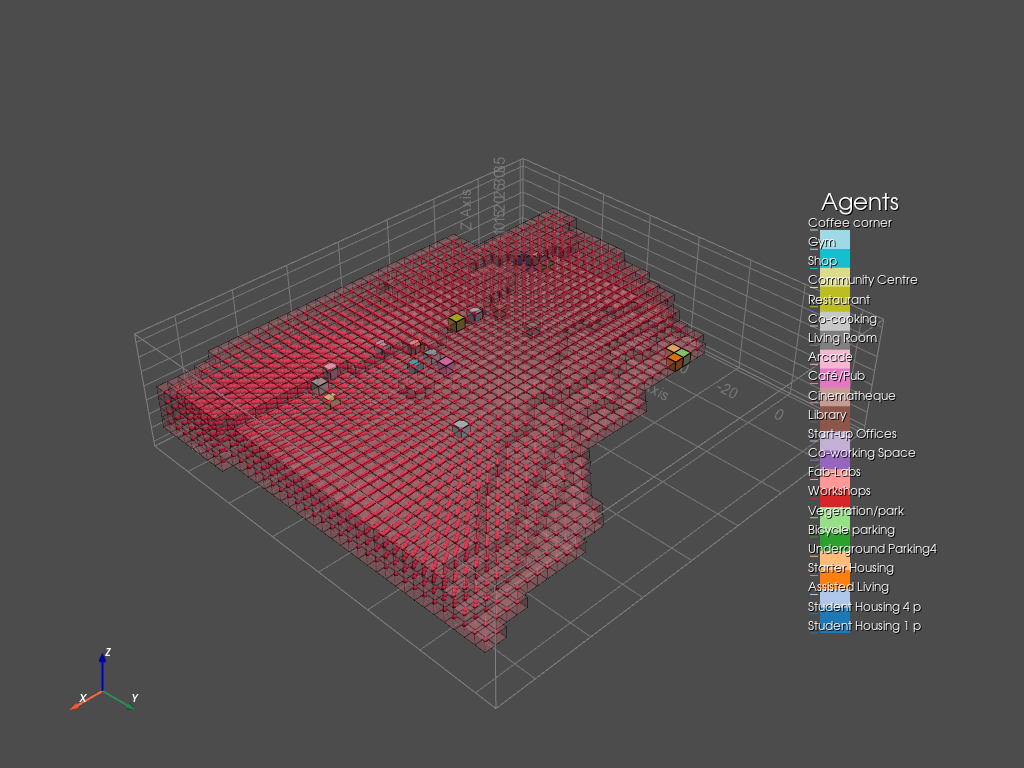

[(275.910778145043, 194.91077814504303, 257.91077778741516),
 (36.0, -45.0, 17.99999964237213),
 (0.0, 0.0, 1.0)]

In [15]:
p = pv.Plotter(notebook=True)

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(occ_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = occ_lattice.minbound - occ_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = occ_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#777777")

# making space list with index for the sargs
space_list = program_complete.get('space_name')
# formatting for the sarg annotation
space_list = space_list.to_dict()

sargs = dict(
    shadow = True,
    n_labels = 0,
    italic = False,
    fmt=" %.0f",
    font_family="arial",
    height = 0.6,
    vertical = True,
    position_x = 0.8,
    position_y = 0.75)
    
# Add the data values to the cell data
grid.cell_arrays["Agents"] = occ_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([-0.1, agn_num - 0.9])
# adding the voxels
p.add_mesh(threshed, show_edges=True, opacity=1.0, show_scalar_bar=True, annotations = space_list, scalar_bar_args=sargs, cmap= "tab20")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

p.show()

## 2. ABM Simulation (Agent Based Space Occupation)

In [16]:
# Calculate distance
# This is a stupid but doable estimate for faster calculation
lattice_cens = init_avail_lattice.centroids_threshold(-1)
def distance(a_id,fns):
    fns_cens = []
    for fn in fns:
        fns_cens.append(lattice_cens[np.ravel_multi_index(fn,avail_lattice.shape)])
    
    dist_m = []
    for voxel_cen in fns_cens:
        diff = voxel_cen - np.average(agn_locs[a_id],axis=0)
        diff_p2 = diff**2
        diff_p2s = diff_p2.sum()
        dist = diff_p2s**0.5
        dist_m.append(dist)
    dist_m = np.array(dist_m)
    return(dist_m)

### 2.1. Running the simulation

In [17]:
# make a deep copy of occupation lattice
cur_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
# initialzing the list of frames
frames = [cur_occ_lattice]

# setting the time variable to 0
t = 0

# main feedback loop of the simulation (for each time step ...)
while t<n_frames: # For every time
    n_fns = 0
    # for each agent ...
    for a_id, a_prefs in program_complete.iterrows():
        # retrieve the list of the locations of the current agent
        a_locs = agn_locs[a_id]
        # initialize the list of free neighbours
        free_neighs = []
        free_neighs_sq = []
        # for each location of the agent
        for loc in a_locs:
            # retrieve the list of neighbours of the agent based on the stencil
            neighs = avail_lattice.find_neighbours_masked(stencil, loc = loc)
            neighs_sq = avail_lattice.find_neighbours_masked(stencil_sq, loc = loc)
            # for each neighbour ... 
            for n in neighs:
                # compute 3D index of neighbour
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape) # for checking availability
                # if the neighbour is available... 
                if avail_lattice[neigh_3d_id]: # True -> Free
                    # add the neighbour to the list of free neighbours
                    free_neighs.append(neigh_3d_id) # Do not care about counting for the second time.
            for n in neighs_sq:
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                if avail_lattice[neigh_3d_id]:
                    free_neighs_sq.append(neigh_3d_id)

        # Investigate no possible free space
        
        if not len(free_neighs)>0:
            n_fns += 1
        # check if found any free neighbour
        if len(free_neighs)>0:
            # convert free neighbours to a numpy array
            fns = np.array(free_neighs)

            # find the value of neighbours
            # init the agent value array
            a_eval = np.ones(len(fns)) # First set all values to 1
            # This is the part to make amandment on choosing which block
            # for each field...
            for f in program_prefs.columns: # f represents names
                # find the raw value of free neighbours...
                vals = fields[f][fns[:,0], fns[:,1], fns[:,2]] # vals should be an array of length of fns
                # raise the the raw value to the power of preference weight of the agent
                a_weighted_vals = vals ** a_prefs[f]
                # multiply them to the previous weighted values
                a_eval *= a_weighted_vals
            
            # now this part add the desirable space vicinity into the account
            for s in program_test.columns:
                s = int(s)
                vals = distance(s,fns)
                a_weighted_vals = vals ** program_test[str(a_id)][s]
                a_eval *= a_weighted_vals

            # This is the part that takes square shape of room into the account
            free_neighs_count = []
            # count can find how many times a location appears
            for free_neigh in free_neighs:
                free_neighs_count.append(free_neighs_sq.count(free_neigh))
            # If a location is pointed for several times, it refers to more squared shape
            a_weighted_square = np.array(free_neighs_count) ** square_weight
            a_eval *= a_weighted_square

            # Here, when it reaches the maximum space needed, start to evaluate inner voxels
            current_length = np.copy(len(a_locs))
            # This part means nothing, just for prevention of bugs
            i_eval = np.zeros(current_length)
            # max_space can be modified, or iterable (max_space[a_id])
            max_space_raw = agent_areas[a_id] / (avail_lattice.unit[0] * avail_lattice.unit[1])
            max_space = np.rint(max_space_raw)
            #max_space = 20
            # If the space occupied by this agent reaches designated
            if current_length >= max_space:
                i_eval = np.ones(current_length)
                # The following parts do exactly the same calculations
                # Calculating fields
                for f in program_prefs.columns:
                    vals = fields[f][np.array(a_locs)[:,0], np.array(a_locs)[:,1], np.array(a_locs)[:,2]]
                    a_weighted_vals = vals ** a_prefs[f]
                    i_eval *= a_weighted_vals

                # Calculating closeness
                for s in program_test.columns:
                    s = int(s)
                    vals = distance(s,np.array(a_locs))
                    a_weighted_vals = vals ** program_test[str(a_id)][s]
                    i_eval *= a_weighted_vals
                
                # Calculating squareness is bit different but the idea is same.
                i_neighs_count = np.zeros(current_length)
                for id,loc in enumerate(a_locs):
                    # Find neighbors of each point in location
                    neighs = init_avail_lattice.find_neighbours_masked(stencil_sq, loc = loc)
                    for n in neighs:
                        # Use occ_lattice == a_id to check if the neighborhoods of that point are the same agent.
                        neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                        i_neighs_count[id] += (occ_lattice==a_id)[neigh_3d_id]
                i_weighted_square = np.array(i_neighs_count) ** square_weight
                i_eval *= i_weighted_square

            # select the inner with lowest evaluation
            selected_int_inner = np.argmin(i_eval)
            # select the neighbour with highest evaluation
            selected_int = np.argmax(a_eval)

            # If the agent reaches the required space, and the new free neighbour is better
            # Then we have to remove the old voxel
            if (current_length >= max_space) and i_eval[selected_int_inner] < a_eval[selected_int]:
                selected_inner_3d_id = tuple(a_locs[selected_int_inner])
                selected_inner_loc = a_locs[selected_int_inner]
                agn_locs[a_id].pop(selected_int_inner)
                avail_lattice[selected_inner_3d_id] = 1
                occ_lattice[selected_inner_3d_id] = -1

            # If the agent does not reach the required space, or we already removed old voxel
            # Then we need to add new voxel
            if current_length < max_space:
                # find 3D integer index of selected neighbour
                selected_neigh_3d_id = free_neighs[selected_int]
                # find the location of the newly selected neighbour
                selected_neigh_loc = np.array(selected_neigh_3d_id).flatten()
                # add the newly selected neighbour location to agent locations
                agn_locs[a_id].append(selected_neigh_loc)
                # set the newly selected neighbour as UNavailable (0) in the availability lattice
                avail_lattice[selected_neigh_3d_id] = 0
                # set the newly selected neighbour as OCCUPIED by current agent 
                # (-1 means not-occupied so a_id)
                occ_lattice[selected_neigh_3d_id] = a_id
            
            # If the agent reaches the required space and the old voxels are better, we do nothing

    # constructing the new lattice
    new_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
    # adding the new lattice to the list of frames
    frames.append(new_occ_lattice) # For drawing graphes
    # adding one to the time counter
    print(t,"/",n_fns, end="  ")
    t += 1

divide by zero encountered in power
invalid value encountered in multiply


0 / 0  1 / 0  2 / 0  3 / 0  4 / 0  5 / 0  6 / 0  7 / 0  8 / 0  9 / 0  10 / 0  11 / 0  12 / 0  13 / 0  14 / 0  15 / 0  16 / 0  17 / 0  18 / 0  19 / 0  20 / 0  21 / 0  22 / 0  23 / 0  24 / 0  25 / 0  26 / 0  27 / 0  28 / 0  29 / 0  30 / 0  31 / 0  32 / 0  33 / 0  34 / 0  35 / 0  36 / 0  37 / 0  38 / 0  39 / 0  40 / 0  41 / 0  42 / 0  43 / 0  44 / 0  45 / 0  46 / 0  47 / 0  48 / 0  49 / 0  50 / 0  51 / 0  52 / 0  53 / 0  54 / 0  55 / 0  56 / 0  57 / 0  58 / 1  59 / 1  60 / 1  61 / 1  62 / 1  63 / 3  64 / 3  65 / 3  66 / 3  67 / 3  68 / 3  69 / 3  70 / 3  71 / 3  72 / 3  73 / 3  74 / 3  75 / 3  

divide by zero encountered in power


76 / 3  77 / 3  78 / 3  79 / 3  80 / 3  81 / 3  82 / 3  83 / 3  84 / 3  85 / 3  86 / 3  87 / 3  88 / 3  89 / 3  90 / 4  91 / 4  92 / 4  93 / 4  94 / 4  95 / 4  96 / 4  97 / 4  98 / 4  99 / 4  100 / 4  101 / 4  102 / 4  103 / 5  104 / 5  105 / 5  106 / 5  107 / 5  108 / 5  109 / 5  110 / 5  111 / 5  112 / 5  113 / 5  114 / 4  115 / 5  116 / 5  117 / 5  118 / 5  119 / 5  120 / 4  121 / 5  122 / 4  123 / 5  124 / 4  125 / 5  126 / 4  127 / 5  128 / 4  129 / 5  130 / 5  131 / 5  132 / 5  133 / 5  134 / 4  135 / 5  136 / 4  137 / 5  138 / 4  139 / 5  140 / 4  141 / 5  142 / 5  143 / 5  144 / 5  145 / 5  146 / 5  147 / 5  148 / 5  149 / 5  150 / 5  151 / 5  152 / 5  153 / 5  154 / 5  155 / 5  156 / 5  157 / 5  158 / 5  159 / 5  160 / 5  161 / 5  162 / 5  163 / 5  164 / 5  165 / 5  166 / 5  167 / 5  168 / 5  169 / 5  170 / 5  171 / 5  172 / 5  173 / 5  174 / 5  175 / 5  176 / 5  177 / 5  178 / 5  179 / 5  180 / 5  181 / 6  182 / 6  183 / 6  184 / 6  185 / 6  186 / 6  187 / 6  188 / 6  189 / 6

### 2.2. Visualizing the simulation

In [ ]:
p = pv.Plotter(notebook=True)

base_lattice = frames[0]

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    f = int(value)
    lattice = frames[f]

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, agn_num - 0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)
    return

p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

In [ ]:
agn = 1
p = pv.Plotter(notebook=True)

base_lattice = frames[0]

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    f = int(value)
    lattice = frames[f]

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([agn-0.1, agn+0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)
    return

p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

### 2.3. Saving lattice frames in CSV

In [ ]:
for i, lattice in enumerate(frames):
    csv_path = os.path.relpath('../Data/dynamic output/abm_animation/abm_f_'+ f'{i:03}' + '.csv')
    lattice.to_csv(csv_path)

### Credits

In [ ]:
__author__ = "Shervin Azadi "
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Agent Based Models for Generative Spaces"